In [ ]:
!pip install twstock


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.1/626.1 kB 7.3 MB/s eta 0:00:00


# 取得資料

In [ ]:
import twstock
import datetime
import pandas as pd  #for 資料表格化

stock = twstock.Stock('2603')
today = datetime.date.today()
data = stock.fetch_from(today.year-5, today.month)

# 表格化

In [ ]:
df = pd.DataFrame(data)
dt = df.set_index('date')

df = df.filter(['date','close'])
df = df.rename(columns={'date': 'Date'})
df = df.rename(columns={'close': 'Price(Ground Truth)'})
df

,Date,Price(Ground Truth)
0,2019-11-01,12.50
1,2019-11-04,12.80
2,2019-11-05,12.65
3,2019-11-06,12.80
4,2019-11-07,12.65
...,...,...
1219,2024-11-15,227.50
1220,2024-11-18,224.50
1221,2024-11-19,236.00
1222,2024-11-20,233.50


# 資料視覺化

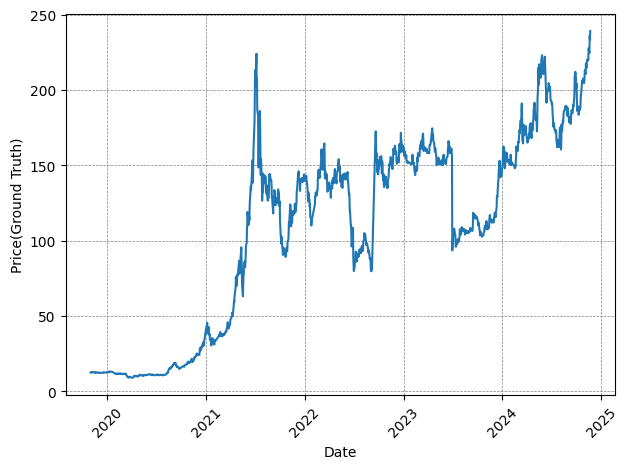

In [ ]:
import matplotlib.pyplot as plt  #for 圖表繪製

DATE = 'Date'
PRICE = 'Price(Ground Truth)'

plt.plot(df[DATE], df[PRICE])
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')  # 虛線網格
plt.xlabel(DATE)
plt.ylabel(PRICE)
plt.xticks(rotation=45)  # 旋轉 x 軸標籤，避免重疊
plt.tight_layout()  # 調整佈局，避免標籤被裁切
plt.show()


# 將資料標準化，以符合AI模型的要求

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))  #將數據壓縮到 0-1 範圍
scaled_data = scaler.fit_transform(df[PRICE].values.reshape(-1,1))  #將壓縮的資料標準化
scaled_data

array([[0.01478904],
       [0.01609395],
       [0.0154415 ],
       ...,
       [0.98695085],
       [0.97607656],
       [1.        ]])

# 建構數據集

In [ ]:
import numpy as np
MOVING_WIN_SIZE = 30 #定義移動窗口大小為x天

all_x, all_y = [], []
for i in range(len(scaled_data) - MOVING_WIN_SIZE):
  x = scaled_data[i:i+MOVING_WIN_SIZE]  #每次取x天的數據
  y = scaled_data[i+MOVING_WIN_SIZE]  #對應第x天的數據
  all_x.append(x)
  all_y.append(y)
all_x, all_y = np.array(all_x), np.array(all_y)
print(all_x.shape)
print(all_y.shape)

(1194, 30, 1)
(1194, 1)


# Split DataSets

In [ ]:
DS_SPLIT = 0.8  #將數據集分為80%訓練，20%測試

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(955, 30, 1)
(955, 1)
(239, 30, 1)
(239, 1)


# 建立模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()  #初始化模型
#第一層設置 return_sequences=True 以輸出序列。
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
#第二層設置 return_sequences=False 以輸出最終狀態。
model.add(LSTM(units=50, return_sequences=False))
#增加兩層全連接層 (Dense)：
#第一層有 25 個神經元。
model.add(Dense(units=25))
#第二層有 1 個神經元，輸出預測值。
model.add(Dense(units=1))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          epochs=500,
          callbacks=[early_stop])

Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0638 - val_loss: 0.0026
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 10/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Evaluate Model

In [ ]:
preds = model.predict(test_x)  #使用測試資料預測
preds = scaler.inverse_transform(preds)  #還原到原始價格範圍


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


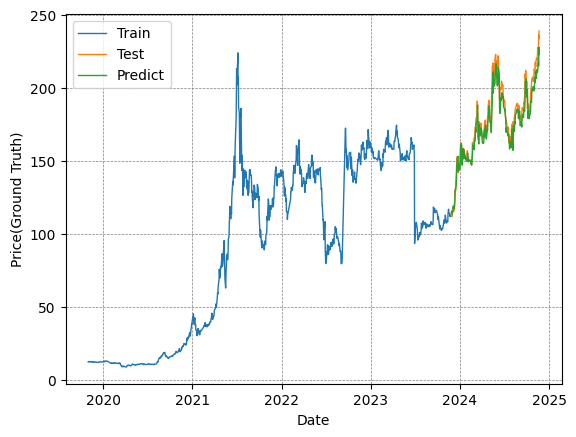

In [ ]:
train_df = df[:train_ds_size+MOVING_WIN_SIZE]
test_df = df[train_ds_size+MOVING_WIN_SIZE:]
test_df = test_df.assign(Predict=preds)


plt.xlabel(DATE)
plt.ylabel(PRICE)
plt.plot(train_df[DATE],train_df[PRICE], linewidth=1)
plt.plot(test_df[DATE],test_df[PRICE], linewidth=1)
plt.plot(test_df[DATE],test_df['Predict'], linewidth=1)
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')  # 虛線網格
plt.legend(['Train', 'Test', 'Predict'])
plt.show()

In [ ]:
last_30_days = scaled_data[-MOVING_WIN_SIZE:]  #取得最後30天的資料
last_30_days = np.array(last_30_days).reshape(1, MOVING_WIN_SIZE, 1)  #將最後30天的資料轉換成模型輸入格式

# 使用模型預測未來10天的價格
predicted_prices = []
for i in range(10):
  predicted_price = model.predict(last_30_days)
  predicted_prices.append(predicted_price[0][0])

  # 將預測的價格加入到最後30天的資料中，作為新的輸入
  last_30_days = np.append(last_30_days[0][1:], [[predicted_price[0][0]]], axis=0)
  last_30_days = last_30_days.reshape(1, MOVING_WIN_SIZE, 1)

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

print("預測未來10天價格：")
for i, price in enumerate(predicted_prices):
  print(f"第{i+1}天：{price[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
預測未來10天價格：
第1天：229.12477111816406
第2天：216.63299560546875
第3天：204.30746459960938
第4天：193.044189453125
第5天：183.5155487060547
第6天：175.649169921875
第7天：169.00210571289062
第8天：163.09765625
第9天：157.5968780517578
第10天：152.34130859375
